# Shallow water equations with ExaHyPE 2 and GeoClaw
 
A solver of the SWE equations that relies on ClawPack's point-wise SWE solver and GeoClaw.

In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use and we have to give it a name. There are a few more options that we omit here, i.e. we use the defaults.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "swe"], "exaclaw" )

## The simplest ExaClaw Finite Volumes solver

Our first step is to use a Finite Volumes solver. We refer them as ExaClaw solvers. ExaClaw is the research project, where we promised to marry ExaHyPE and ClawPack's Riemann solvers. The actual softare is still ExaHyPE + ClawPack. The ClawPack solver is similar to the Euler one. Instead of a (generic) flux and eigenvalue, it needs the name of the ClawPack Riemann solver plus the Fortran file with the implementation. The latter actually can be a set of Fortran files for more complex solvers.

In [4]:
patch_size     = 11
unknowns       = 3        # height and two velocities
auxiliary_variables = 1   # bathymetry
time_step_size = 0.0001
max_h          = 0.1
min_h          = 0.1

my_solver = exahype2.solvers.fv.PointWiseClawPackFixedTimeStepSize(
  name="SWE", patch_size=patch_size, unknowns=unknowns, 
  auxiliary_variables=auxiliary_variables, min_h=min_h, max_h=max_h, 
  time_step_size=0.0001,
  clawpack_Riemann_solver="rpn2", 
  Riemann_solver_implementation_files=["/home/marion/workspace/Projects/ExaClaw/Peano/examples/exahype2/swe/rpn2_ptwise_geoclaw.f90"],
  discriminate_normal=True  
)
project.add_solver( my_solver )


The two fundamental pieces of info we still have to feed into the solver are proper boundary and initial conditions. I use some factory/symbolic mechanisms here for the boundary conditions. For the initial condition, I could just omit the parameter. I'd then get a file Acoustic.cpp with an empty function that I have to implement. As this function will be close to trivial once more, I directly inject the C++ code here. So I don't have to touch any C++ code while I run the Juptyer notebook.

In [5]:
import exahype2.sympy

pde = exahype2.sympy.PDE(unknowns=3,auxiliary_variables=1,dimensions=2)

my_solver.set_implementation(
  boundary_conditions=pde.implementation_of_homogeneous_Neumann_BC(),
  initial_conditions="""
   Q[0] = (volumeCentre(0)-0.5)*(volumeCentre(0)-0.5) + (volumeCentre(1)-0.5)*(volumeCentre(1)-0.5) < 0.1*0.1 ? 0.2 : 0.1;
   Q[1] = 0.0;
   Q[2] = 0.0;
   Q[3] = 1.0; // bathymetry
  """
)   


## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [6]:
build_mode = peano4.output.CompileMode.Asserts
#build_mode = peano4.output.CompileMode.Release

dimensions = 2

end_time = 0.005
    
project.set_global_simulation_parameters(
  2,                        # dimensions
  [0.0,0.0],  [1.0,1.0],
  end_time,                 # end time
  0.0, time_step_size*10    # snapshots
)

## Generate a Peano 4 project

This is exactly the same as for Euler: We ask the ExaHyPE 2 frontend to give us a Peano project.

In [7]:
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
used Fortran compiler is gfortran


A "big" difference to Euler is that we now have some external Fortran files. Usually, we take the default settings when we invoke the Fortran compiler. Default is the stuff given to us by Peano's configure. There's however the opportunity to add further flags manually. I use this here to inject debug info.

In [8]:
peano4_project.output.makefile.add_Fortran_flag( "-g" )
peano4_project.output.makefile.add_library("gfortran")
peano4_project.output.makefile.add_Fortran_module("amr_module.mod",["/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/amr_module.f90"])
peano4_project.output.makefile.add_Fortran_module("geoclaw_module.mod", ["/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/geoclaw_module.f90"])
peano4_project.output.makefile.add_Fortran_module("utility_module.mod", ["/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/utility_module.f90"])
peano4_project.output.makefile.add_header_search_path("/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/")
peano4_project.output.makefile.add_header_search_path("/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/")
peano4_project.output.makefile.add_Fortran_file("/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/riemann/src/geoclaw_riemann_utils.f")
peano4_project.output.makefile.add_Fortran_file("/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/opendatafile.f")
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated exaclaw-main.cpp
write ./Makefile
write ././AbstractSWE.h (generated from template /home/marion/workspace/Projects/ExaClaw/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.h)
write ././AbstractSWE.cpp (generated from template /home/marion/workspace/Projects/ExaClaw/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/marion/workspace/Projects/ExaClaw/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/marion/workspace/Projects/ExaClaw/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/SWEQ.h (generated from template /home/marion/workspace/Projects/ExaClaw/Peano/python/peano4/datamodel/PatchToDouble

In [9]:

#parallel_builds = 8   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
#peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )
!make

g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/ -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/ -DDimensions=2 -I. -I../../../src -c -o AbstractSWE.o AbstractSWE.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/ -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/ -DDimensions=2 -I. -I../../../src -c -o observers/SolverRepository.o observers/SolverRepository.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/ -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/ -DDimensions=2 -I. -I../../../src -c -o celldata/SWEQ.o celldata/SWEQ.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fop

g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/ -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/ -DDimensions=2 -I. -I../../../src -c -o observers/TimeStep2peano4_toolbox_blockstructured_ProjectPatchOntoFaces1.o observers/TimeStep2peano4_toolbox_blockstructured_ProjectPatchOntoFaces1.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/ -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/geoclaw/src/2d/shallow/ -DDimensions=2 -I. -I../../../src -c -o observers/TimeStep2peano4_toolbox_blockstructured_ApplyFunctorOnPatch2.o observers/TimeStep2peano4_toolbox_blockstructured_ApplyFunctorOnPatch2.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -I/home/marion/workspace/Projects/ExaClaw/clawpack/src/clawpack-v5.7.1/amrclaw/src/2d/ -I/home

## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [10]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpirun noticed that process rank 0 with PID 0 on node mizar exited on signal 11 (Segmentation fault).
--------------------------------------------------------------------------

run failed


True

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [11]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
h_min=0.037037
triggered plot at 3.701346545s
started new time step at 4.138593222000001s


In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

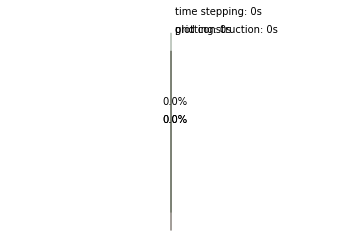

In [12]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

ValueError: max() arg is an empty sequence

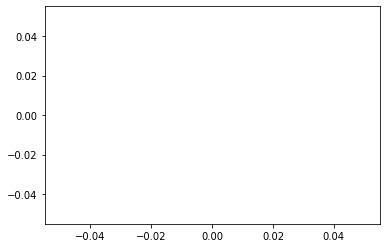

In [13]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

We first do an ls on our directory and search for the root .peano-patch-file. I then convert this file manually into vtu which I can load into Paraview. This works if Peano is configured with vtk support. If you don't have vtk support in there, then you might want to load the data directly into Paraview through Peano's Paraview plug-in.

In [ ]:
!ls